# 第3章 一般化線型モデル（GLM）---ポアソン回帰---

In [1]:
using CSV
using DataFrames
using GLM
using Plots
using StatPlots
using Distributions

説明変数として体サイズ（$x_i$）と施肥効果（$f_i$）、応答変数として種子数（$y_i$）があるとする。

## 3.2 観測されたデータの概要を調べる（p.41）

In [2]:
d = CSV.read("data3a.csv")

,y,x,f
,Int64⍰,Float64⍰,String⍰
1,6,8.31,C
2,6,9.44,C
3,6,9.5,C
4,12,9.07,C
5,10,10.16,C
6,4,8.32,C
7,9,10.61,C
8,9,10.06,C
9,9,9.93,C


In [3]:
DataFrames.describe(d)   # Rのsummaryっぽいやつ

,variable,mean,min,median,max,nunique,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Union…,Int64,DataType
1,y,7.83,2,8.0,15,,0,Int64
2,x,10.0891,7.19,10.155,12.4,,0,Float64
3,f,,C,,T,2,0,String


In [4]:
d.x

100-element Array{Union{Missing, Float64},1}:
  8.31
  9.44
  9.5 
  9.07
 10.16
  8.32
 10.61
 10.06
  9.93
 10.43
 10.36
 10.15
 10.92
  8.85
  9.42
 11.11
  8.02
 11.93
  8.55
  7.19
  9.83
 10.79
  8.89
 10.09
 11.63
  ⋮   
 11.76
  9.52
 10.4 
  9.96
 10.3 
 11.54
  9.42
 11.28
  9.73
 10.78
 10.21
 10.51
 10.73
  8.85
 11.2 
  9.86
 11.54
 10.03
 11.88
  9.15
  8.52
 10.24
 10.86
  9.97

In [5]:
typeof(d)

DataFrame

In [6]:
typeof(d.x)

Array{Union{Missing, Float64},1}

In [7]:
typeof(d.f)

Array{Union{Missing, String},1}

## 3.3 統計モデリングの前にデータを図示する（p.44）

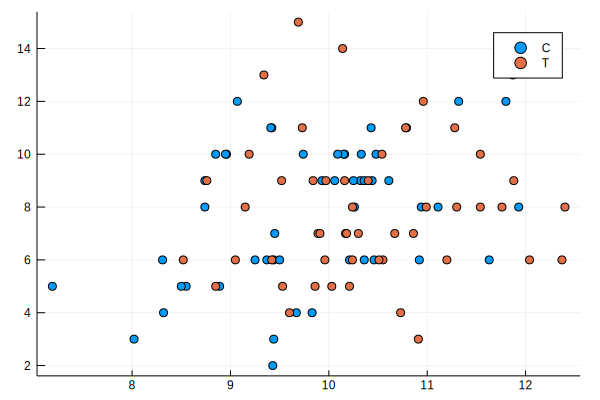

In [8]:
# 素のままのPlots.jlを使った場合
scatter(reshape(d.x, (50, 2)), reshape(d.y, (50, 2)), label=["C", "T"])

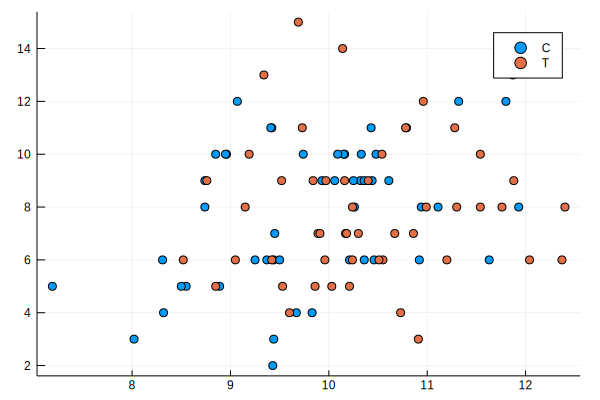

In [9]:
# StatPlots.jlを使った場合
@df d scatter(:x, :y, group=:f)

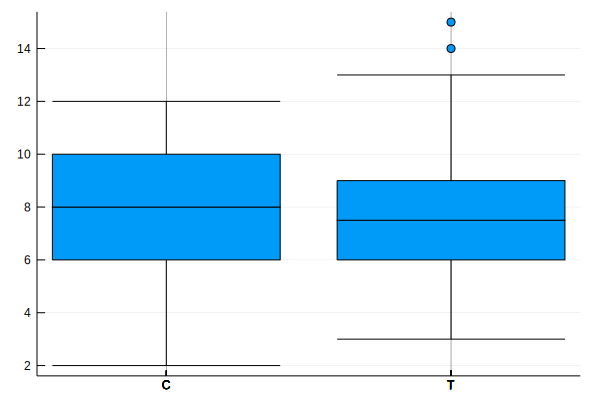

In [10]:
@df d boxplot(:f, :y, legend=false)

### 3.4.1 線形予測子と対数リンク関数（p.47）

たとえばある個体$i$の平均種子数$\lambda_i$が

$$ \lambda_i = \exp\left(\beta_1 + \beta_2 x_i\right) $$

とあらわせるとき、これを

$$ \log_e\lambda_i = \beta_1 + \beta_2 x_i $$

と変形し、右辺（$\beta_1 + \beta_2 x_i$）が**線形予測子**（_linear predictor_）、左辺の関数（$\log_e$）が**リンク関数**（_link function_）となる。

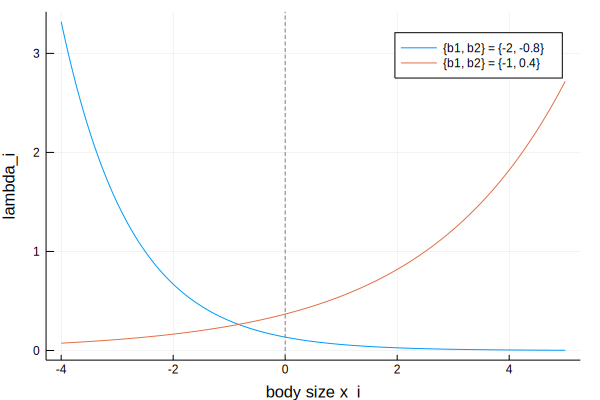

In [11]:
x = range(-4, stop=5, length=1001);
plot(x, exp.(-2 .+ -0.8x), label="{b1, b2} = {-2, -0.8}",
  xlabel="body size x_i", ylabel="lambda_i")
plot!(x, exp.(-1 .+ 0.4x), label="{b1, b2} = {-1, 0.4}")
vline!([0], color=:grey, linestyle=:dash, label="")

### 3.4.2 あてはめとあてはまりの良さ（p.49）

In [12]:
fit1 = glm(@formula(y ~ x), d, Poisson(), LogLink())

┌ Warning: In the future eachcol will have names argument set to false by default
│   caller = evalcontrasts(::DataFrame, ::Dict{Any,Any}) at modelframe.jl:124
└ @ StatsModels /Users/marui/.julia/packages/StatsModels/AYB2E/src/modelframe.jl:124


StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x

Coefficients:
              Estimate Std.Error z value Pr(>|z|)
(Intercept)    1.29172  0.363686 3.55174   0.0004
x            0.0756619 0.0356042 2.12509   0.0336


In [13]:
# 推定値
fit1.model.pp.beta0

2-element Array{Float64,1}:
 1.291720838655208  
 0.07566191453957867

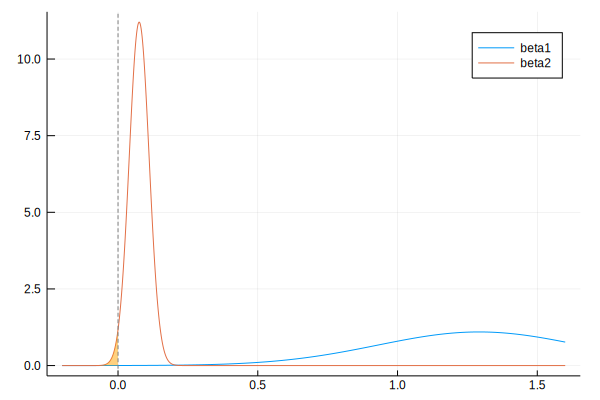

In [14]:
# Figure 3.6
th = range(-0.2, stop=1.6, length=1001);
plot(th, pdf.(Normal(1.29172, 0.363686), th), label="beta1")
plot!(th, pdf.(Normal(0.0756619, 0.0356042), th), label="beta2")
plot!(th[th .<= 0], pdf.(Normal(0.0756619, 0.0356042), th[th .<= 0]), linealpha=0, fill=(0, 0.5, :orange), label="")
vline!([0], color=:grey, linestyle=:dash, label="")

In [15]:
# 最大対数尤度（maximum log likelihood）
loglikelihood(fit1)

-235.38625076986077

In [16]:
fit2 = glm(@formula(y ~ x + f), d, Poisson(), LogLink())

StatsModels.DataFrameRegressionModel{GeneralizedLinearModel{GlmResp{Array{Float64,1},Poisson{Float64},LogLink},DensePredChol{Float64,LinearAlgebra.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: y ~ 1 + x + f

Coefficients:
               Estimate Std.Error   z value Pr(>|z|)
(Intercept)     1.26311  0.369629   3.41722   0.0006
x             0.0800726 0.0370369   2.16197   0.0306
f: T         -0.0319994 0.0743789 -0.430221   0.6670
